In [64]:
import numpy as np
from scipy.misc import logsumexp
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

class HMM():
    def __init__(self, transition, mu,sigma, obs,T,pi, q):
        self.transition = transition 
        self.state=[0,1,2,3] 
        self.pi=pi
        self.mu = mu
        self.sigma = sigma
        self.obs=obs
        self.T=T
        self.q=np.zeros(T)
        self.emissions = np.zeros((T, 4))
        self.label_cond_probas = np.zeros((T,4))

   
        
    def estimate_labels_cond_probas(self):
        """ Estimate p(Qt \ ut)"""
        for i, xi in enumerate(self.obs):
            probs = np.zeros(4)
            for q in self.state:
                prob = self.alphas[i,q] + self.betas[i,q]
               
                probs[q] = prob
  
            self.label_cond_probas[i] = np.exp(probs - logsumexp(probs))
        
         
    def estimate_emissions(self):
        """Estimate p(ut \ qt)"""
        for i,xi in enumerate(self.obs):
            probs = self.multivariate_gaussian(xi)
            self.emissions[i, :] = self.multivariate_gaussian(xi)
        
    
    def multivariate_gaussian(self, xi):
        """ Computes the vector of the probabilities p(u_t | q_t=i )"""
        probs = np.zeros(4)
        mu = self.mu
        sigmas = self.sigma
        inv_sigmas = [np.linalg.inv(sigmas[j]) for j in range(4)]
        det_sigmas = [np.linalg.det(sigmas[j]) for j in range(4)]
        for j in range(4):
            x_m = (xi-mu[j]).reshape(2,1)
            probs[j] = math.exp(- x_m.T.dot(inv_sigmas[j]).dot(x_m) / 2)
            probs[j] /= (2 * math.pi * math.sqrt(det_sigmas[j]))

       
        return probs
    
        
    def alpha_(self):
        """ Estimate log alpha """
        alphas = np.zeros((self.T,4))
        alphas[0] = np.log(self.pi)
        
        for index in range(1,self.T):
            probs = np.log(self.emissions[index])
          
            result = np.zeros(4)
            for q in self.state:
                result[q] = probs[q] + logsumexp(np.log(self.transition[q,:]) + alphas[index-1])
             
            alphas[index] = result
        self.alphas = alphas


    def beta_(self): 
        """ Estimate log beta"""
        betas = np.zeros((T,4))
        
        betas[(T-1)] = [0,0,0,0]
        for index in range((self.T-2),-1,-1):
            probs = np.log(self.emissions[index])
            result = np.zeros(4)
            for q in self.state:
                result[q] = probs[q] + logsumexp(np.log(self.transition[:,q]) + betas[index+1])
            betas[index] = result
        self.betas = betas

    def estimate_transition(self):
        """ Estimte p(zt+1 \ zt)"""
        new_transition = np.zeros((4,4))
        alphas = self.alphas
        betas = self.betas
        for k in range(4):
            for l in range(4):
                res=0
               
                for index in range(self.T):
                    
                    log_inter_prob = np.log(self.transition[k,l]) + np.log(self.emissions[index, l]) 
                    log_inter_prob += alphas[index,l] + betas[index,k]
                    log_inter_prob /= logsumexp(alphas[index,:] + betas[index,:])
                    res += np.exp(log_inter_prob)
                
                new_transition[k,l] = res 
                
            new_transition[k,:] /= np.sum(new_transition[k,:])
        
        self.transition = new_transition


    
    def estimate_mu(self):
        """ Estimate mu """
        for k in range(4):
            res=0
            for index in range(self.T):
                res += self.label_cond_probas[index,k] * self.obs[index] 
            self.mu[k] = res / np.sum(self.label_cond_probas[:,k])
      
        return self.mu
    
    def estimate_sigma(self):   
        """ Estiamate sigma """
        for k in range(4):
            res=0
            for index in range(self.T):
                x_u = self.obs[index] - self.mu[k]
                x_u = x_u.reshape(2,1)
                res += self.label_cond_probas[index,k] * np.outer(x_u, x_u)
            self.sigma[k] = res / np.sum(self.label_cond_probas[:,k])
        
        return self.sigma
    
    
    def estimate_multinomial(self):
        for k in range(4):
            self.pi[k] = self.label_cond_probas[0,k] / np.sum(self.label_cond_probas[0,:])
        return self.pi
    
    
    def estimate_log_likelihood(self, q):
        
        loss = 0
        q = [int(r) for r in q]
        inv_sigmas = [np.linalg.inv(self.sigma[j]) for j in range(4)]
        det_sigmas = [np.linalg.det(self.sigma[j]) for j in range(4)]
        
        loss += np.log(self.pi[q[0]])
        
        for index in range(self.T-1):
            k = q[index]
            l = q[index + 1]
            loss += np.log(self.transition[k,l])
        
        for index in range(self.T):
            k = q[index]
            a = - np.log(det_sigmas[k]) / 2 - np.log(2 * np.pi) 
              
            x_u = self.obs[index] - self.mu[k]
            x_u = x_u.reshape(2,1)
            a -= x_u.T.dot(inv_sigmas[k]).dot(x_u) / 2
            loss += a 
            
        return -loss
   
      
    
    def plot(self, labels):
        """ Plot the points, centroids and covariance matrices """
        fig = plt.figure(0)
        ax = fig.add_subplot(111, aspect='equal')
        plt.scatter(self.obs[:,0],self.obs[:,1], c=labels, s=1)
        plt.scatter(self.mu[:,0], self.mu[:,1], c='black')
        chi_val = 2.146
        for j in range(len(self.state)):
            points = np.array([xi for i,xi in enumerate(self.obs)
                                  if labels[i] == j])
            cov = self.sigma[j]
            eig_vals, eig_vec = np.linalg.eig(cov)
            eig_vals = np.sqrt(eig_vals)

            ell = Ellipse(xy=self.mu[j],
                          width=eig_vals[0] * chi_val, height=eig_vals[1] * chi_val,
                          angle=np.rad2deg(np.arccos(eig_vec[0, 0])))

            ell.set_facecolor("none")
            ell.set_edgecolor("blue")
            ax.add_artist(ell)
        plt.savefig("HMM_train.png")
            
    def viterbi(self, plot=True):
        """ Viterbi algorithm to estiamte the most likely sequence"""
        self.estimate_emissions()
        viterbi = np.zeros((self.T, len(self.state)))
        viterbi[0,:] = np.log(self.pi) + np.log(self.emissions[0])
        phi = np.zeros((self.T, len(self.state)))
        phi[0,:] = 0
        for t in range(1,self.T):
            for j in range(len(self.state)):
                vtj = viterbi[t-1,:] + np.log(self.transition[:,j]) + np.log(self.emissions[t,j])
                viterbi[t,j] = np.max(vtj)
                phi[t,j] = np.argmax(vtj)
           
        prob = np.max(viterbi[self.T - 1])
        pointer = np.argmax(viterbi[self.T - 1])
        path = [pointer]
        for t in range(1,self.T):
            path = [phi[T - t, int(path[0])]] + path
        if plot:
            self.plot(path)
      
    
        return path 
    
        
    def fit(self, plot=True): 
        """ Fit the model, compute all the parameters"""
        errors = []
        N = 20
        for j in range(N):
           
            self.estimate_emissions()
           
            self.alpha_()
           
            self.beta_()
           
            self.estimate_labels_cond_probas()
           
            self.estimate_transition()
            self.estimate_mu()
            
            self.estimate_sigma()
            self.estimate_multinomial()
            
            errors += [self.estimate_log_likelihood(self.q)[0][0]]
            self.q = np.argmax(self.label_cond_probas, axis=1)
            

        
        


In [65]:
import pandas as pd

def read_file(filename):
    """ Load the data
    return:: x array, y array """
    print("Loading data " + filename)
    df = pd.read_csv(filename, delimiter=' ',  header=None)
    return df.values

filename = "EMGaussian.data"
filename_test = "EMGaussian.test"
x = read_file(filename)
x_test = read_file(filename_test)


Loading data EMGaussian.data
Loading data EMGaussian.test


In [66]:
from emgaussian import EMGaussian
from kmean import KMeans
import matplotlib.pyplot as plt
import math
#Initialize parameters with EMGaussian

emg = EMGaussian(x, isotropic=False)
emg.fit(plot_likelihood=False)
plt.show()

pi=emg.pi
mu=emg.mu
sigma=emg.sigmas
transition = np.array([[0.25, 0.25, 0.25, 0.25], [0.25, 0.25, 0.25, 0.25], [0.25, 0.25, 0.25, 0.25], [0.25, 0.25, 0.25, 0.25]])
obs = x
q = emg.labels
T = x.shape[0]

#HMM
model = HMM(transition, mu,sigma,obs,T,pi, q)


Kmeans converged after 15 iterations, loss: 3240.593025
Fit Gaussian converged after 5 iterations


array([[2374.19931588]])

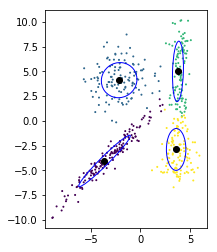

In [67]:
q = model.viterbi()
model.estimate_log_likelihood(q)